<a href="https://colab.research.google.com/github/13693763686/data-analysis/blob/master/scikit-learn%20notebooks/XGBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Boosting算法

In [1]:
#集成算法的效果十分十分的强，在数据竞赛中能取得非常好的效果
#当然集成学习和深度学习擅长的问题不太，在计算机视觉上，显然深度学习是主流，自然语言也是同样
#深度学习在工业上的实践感觉很多，但是boosting更多的是在数据竞赛中吧
#集成算法的数学推导过程不在此笔记本中记录
#下面主要展示原理在机器学习中的应用过程

##导入需要的库

In [2]:
#注意boosting的xgboost具有两种包，可以在sklearn中，也可以直接引用对应的包
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

##导入数据

In [4]:
#获取数据，分离数据和标签
data = load_boston()
X = data.data
y = data.target
Xtrain,Xtest,Ytrain,Ytest = TTS(X,y,test_size=0.3,random_state=420)
reg = XGBR(n_estimators=100).fit(Xtrain,Ytrain) #训练
reg.score(Xtest,Ytest) #你能想出这里应该返回什么模型评估指标么？利用shift+Tab可以知道，R^2评估指标

[12:00:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9197580267581366

In [5]:
#交叉验证
reg = XGBR(n_estimators=100) #交叉验证中导入的没有经过训练的模型
CVS(reg,Xtrain,Ytrain,cv=5).mean()

[12:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8017863029875325

In [13]:
#观察xgboost的学习曲线
def plot_learning_curve(estimator,title, X, y, 
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                       ):
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                  ,shuffle=True
                                  ,cv=cv
                                  ,random_state=420
                                  ,n_jobs=n_jobs)      
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    ax.legend(loc="best")
    return ax

In [14]:
cv = KFold(n_splits=5, shuffle = True, random_state=42) #交叉验证模式

In [ ]:
plot_learning_curve(XGBR(n_estimators=100,random_state=420),"XGB",Xtrain,Ytrain,ax=None,cv=cv)
plt.show()

In [38]:
#一直报warning非常讨厌，把它给去掉
import warnings
warnings.filterwarnings('ignore')

##参数探索

In [ ]:
#探索最优的n_estimators
axisx = range(10,1010,50)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    rs.append(CVS(reg,Xtrain,Ytrain,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()
#观察到在大约150-200的位置的时候，模型的训练误差已经不再变化了，因此比较好的方法是在这个范围内细化再寻找

[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

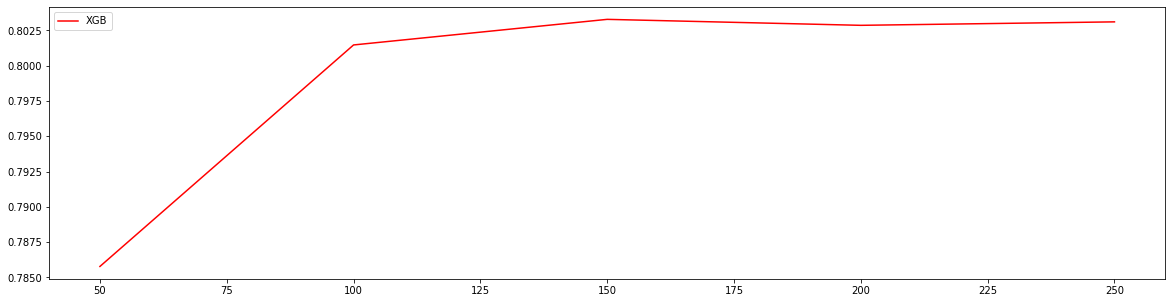

In [24]:
#通过找出方差和偏差的方式来代表偏差和方差
axisx = range(50,300,50)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    #记录1-偏差
    rs.append(cvresult.mean())
    #记录方差
    var.append(cvresult.var())
    #计算泛化误差的可控部分
    #注意误差的分解包括偏差，方差和噪音
    ge.append((1 - cvresult.mean())**2+cvresult.var())
#打印R2最高所对应的参数取值，并打印这个参数下的方差
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
#打印方差最低时对应的参数取值，并打印这个参数下的R2
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
#打印泛化误差可控部分的参数取值，并打印这个参数下的R2，方差以及泛化误差的可控部分
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="red",label="XGB")
plt.legend()
plt.show()

In [ ]:
#对上面的过程细化，减少间隔，发掘潜力
#图像重合的地方且线较高的地方是比较好的地方
axisx = range(100,300,10)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)*0.01
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
#添加方差线
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()
#观察下面的输出，发现偏差和方差最小的地方都是在180的地方，因此180是一个比较好的参数
#这样，我们第一个很重要的参数，树的数目就选择好了

In [25]:
#下面探究另一个参数subsample，指每次随机抽样的个数
#ensemble集成学习的重点在于不同的弱分类器的集合，因此这里面我们看到的就是要求不同的分类器
#不同的分类器可以通过不同的算法，不同的样本，这时候我们就采用bootstrap
#但是既然是boosting，我们还要控制出错的样本被抽到的可能性，这个可以有严格的公式，把相对权重转换成抽样概率
#我们可以指定subsample控制每次抽样的比例，下面来调整这个参数

In [ ]:
#首先仍然是粗略的观察
axisx = np.linspace(0,1,20)
rs = []
for i in axisx:
    reg = XGBR(n_estimators=180,subsample=i,random_state=420)
    rs.append(CVS(reg,Xtrain,Ytrain,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()

In [28]:
#由图像可以发现，效果大约在0.05左右的时候就已经达到最高峰
#下面来调整参数

In [ ]:
#继续细化学习曲线
axisx = np.linspace(0.05,1,20)
rs = []
var = []
ge = []
for i in axisx:
    reg = XGBR(n_estimators=180,subsample=i,random_state=420)
    cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="black",label="XGB")
plt.plot(axisx,rs+var,c="red",linestyle='-.')
plt.plot(axisx,rs-var,c="red",linestyle='-.')
plt.legend()
plt.show()

In [30]:
#这一次可以看到大约在0.8的时候，值达到高峰，且中间的值比较波动
#因此我们可以发现subsampling这个值的调整很微妙，规律不太容易寻找
#因此调整的时候可以不要太在意，满意原则即可，这里我觉得大概是0.8左右

In [31]:
reg = XGBR(n_estimators=180
      ,subsample=0.8
      ,random_state=420).fit(Xtrain,Ytrain)
reg.score(Xtest,Ytest)

[12:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.922624813518896

In [32]:
#结果来看其实提升并没有多大，在没有调整subsampling的时候，我们的分数也差不多如此

In [35]:
#为了便于后续的模型比较
#我们先来定义一个评分函数，这个评分函数能够帮助我们直接打印Xtrain上的交叉验证结果
def regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2"],show=True):
    score = []
    for i in range(len(scoring)):
        temp_score = CVS(reg,Xtrain,Ytrain,cv=cv,scoring=scoring[i]).mean()
        if show:
            print("{}:{:.2f}".format(scoring[i],temp_score))
        score.append(temp_score)
    return score

In [ ]:
#下面来探索学习率alpha参数的调整
#梯度下降法的alpha和这里差不多的概念，因为boosting本身也是一个梯度方法，尽管是一个函数梯度，这个地方的方向可以增加学习率
#注意观察学习率为0的时候的结果，相当于我们没有集成任何的后续的树
from time import time
import datetime

for i in [0,0.2,0.5,1]:
    time0=time()
    reg = XGBR(n_estimators=180,random_state=420,learning_rate=i)
    print("learning_rate = {}".format(i))
    regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2","neg_mean_squared_error"])
    print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))

In [ ]:
#观察不同学习率下的效果
axisx = np.arange(0.05,1,0.05)
rs = []
te = []
for i in axisx:
    reg = XGBR(n_estimators=180,random_state=420,learning_rate=i)
    score = regassess(reg,Xtrain,Ytrain,cv,scoring = ["r2","neg_mean_squared_error"],show=False)
    test = reg.fit(Xtrain,Ytrain).score(Xtest,Ytest)
    rs.append(score[0])
    te.append(test)
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,te,c="gray",label="test")
plt.plot(axisx,rs,c="green",label="train")
plt.legend()
plt.show()

##算法的粗略解释

###booster

In [39]:
#boosting是一种思想，是不断的改进的思想，树的模型是最常用的基本算法
#但是同样的，线性的算法也可以被boosting不断加强，然后集合起来
for booster in ["gbtree","gblinear","dart"]:
    reg = XGBR(n_estimators=180
               ,learning_rate=0.1
               ,random_state=420
               ,booster=booster).fit(Xtrain,Ytrain)
    print(booster)
    print(reg.score(Xtest,Ytest))

[12:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
gbtree
0.9231068620728082
[12:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
gblinear
0.6286510307485139
[12:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
dart
0.923106843149575


In [40]:
#发现明显树的模型表现得好很多，因此，xgboost总是基于树模型的，基于其它模型的xgboost需要不同的推导方式

In [44]:
#下面使用原生的xgboost进行操作，它的cv给出了更好的信息
import xgboost as xgb
dfull = xgb.DMatrix(X,y)

In [45]:
#设定参数，注意train的过程只接受训练数据，树的数目和params--所有的选项
param1 = {'silent':True,'obj':'reg:linear',"gamma":0}
num_round = 100
n_fold=5 #sklearn - KFold

In [48]:
ime0 = time()
cvresult1 = xgb.cv(param1, dfull, num_round,n_fold)

In [50]:
cvresult1#这个矩阵可以清晰地看出变化的趋势，可以作图看一下

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.105577,0.129117,17.163215,0.584297
1,12.337972,0.097556,12.519736,0.473458
2,8.994071,0.065756,9.404534,0.472310
3,6.629480,0.050323,7.250335,0.500342
4,4.954407,0.033209,5.920812,0.591874
...,...,...,...,...
95,0.025204,0.005145,3.669921,0.858313
96,0.024422,0.005242,3.669983,0.858255
97,0.023661,0.005117,3.669947,0.858332
98,0.022562,0.004704,3.669868,0.858578


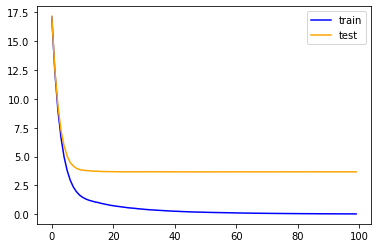

In [60]:
#fig = plt.figure()
cvresult1["train-rmse-mean"].plot(c="blue",label="train")
cvresult1["test-rmse-mean"].plot(c="orange",label="test")
plt.legend()
#由图像可以清楚的观察到训练误差在不断地下降

###Gamma参数

In [61]:
#下面我们来探究非常重要的gamma参数，由于gamma参数里面涉及到非常多的数学技巧，这里不再赘述，希望能落到纸上来仔细研究
#但大体来讲，我们的想法是这样的，每一次的树仍然是贪婪算法，在每一片叶子上达到效果
#这样的话我们看的就是信息的增益，即下降的值代表纯度的提高
#这时候的推导过程中会发现，下降的值总是需要减一个gamma
#因此，gamma越大，剪枝的可能性就越大，因此，这里来考虑一下剪枝的效果，防止过拟合的效果

In [62]:
from sklearn.datasets import load_breast_cancer
data2 = load_breast_cancer()

x2 = data2.data
y2 = data2.target

dfull2 = xgb.DMatrix(x2,y2)

param1 = {'silent':True,'obj':'binary:logistic',"gamma":0,"nfold":5
          ,"eval_metrics":"error"
         }
param2 = {'silent':True,'obj':'binary:logistic',"gamma":1,"nfold":5}
num_round = 100

In [63]:
cvresult1 = xgb.cv(param1, dfull2, num_round,metrics=("error"))
cvresult2 = xgb.cv(param2, dfull2, num_round,metrics=("error")) 

In [ ]:
cvresult1

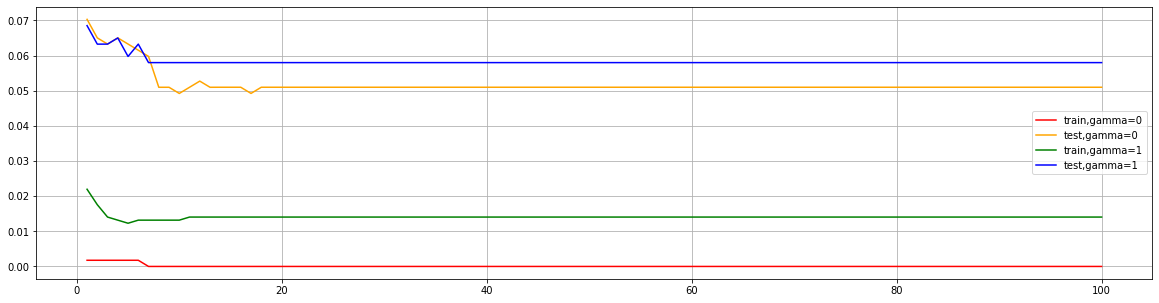

In [66]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(range(1,101),cvresult1.iloc[:,0],c="red",label="train,gamma=0")
plt.plot(range(1,101),cvresult1.iloc[:,2],c="orange",label="test,gamma=0")
plt.plot(range(1,101),cvresult2.iloc[:,0],c="green",label="train,gamma=1")
plt.plot(range(1,101),cvresult2.iloc[:,2],c="blue",label="test,gamma=1")
plt.legend()
plt.show()
#观察train和test的差距实在太大，过拟合比较严重，且gamma为0时候的结果好一点
#下面的过程就是不断地找到最佳的参数，不断地调整和比较

In [91]:
dtrain = xgb.DMatrix(Xtrain,Ytrain)
#设定参数，对模型进行训练
param = {'silent':True
          ,'obj':'reg:linear'
          ,"subsample":1
          ,"eta":0.05
          ,"gamma":20
          ,"lambda":3.5
          ,"alpha":0.2
          ,"max_depth":4
          ,"colsample_bytree":0.4
          ,"colsample_bylevel":0.6
          ,"colsample_bynode":1}
num_round = 180

bst = xgb.train(param, dtrain, num_round)

In [92]:
from sklearn.metrics import mean_squared_error as MSE, r2_score

In [ ]:
#可以直接指定特征矩阵和标签矩阵的综合，结果一致，可能在设计的时候就考虑了只需要对应的特征数了吧
ypreds = xgb.predict(dtrain)

In [93]:
#很尴尬，感觉只能再次调用sklearn中的包来解析error，我找不到xgboost内部自带的scoe功能
r2_score(Ytrain,ypreds)

0.9560783716555461

##不均衡样本下的表现

In [95]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier as XGBC
from sklearn.datasets import make_blobs #自创数据集
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import confusion_matrix as cm, recall_score as recall, roc_auc_score as auc

In [96]:
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

In [97]:
Xtrain, Xtest, Ytrain, Ytest = TTS(X,y,test_size=0.3,random_state=420)

In [98]:
#sklearn下的建模
clf = XGBC().fit(Xtrain,Ytrain)
ypred = clf.predict(Xtest)

In [99]:
#为异常样本增加权重，利用pos_weight
clf_ = XGBC(scale_pos_weight=10).fit(Xtrain,Ytrain)
ypred_ = clf_.predict(Xtest)
clf_.score(Xtest,Ytest)

cm(Ytest,ypred_,labels=[1,0])

recall(Ytest,ypred_)

auc(Ytest,clf_.predict_proba(Xtest)[:,1])

0.9696356275303644

In [101]:
#观察不同权重下，recall和auc的改变
for i in [1,5,10,20,30]:
    clf_ = XGBC(scale_pos_weight=i).fit(Xtrain,Ytrain)
    ypred_ = clf_.predict(Xtest)
    print(i)
    print("\tAccuracy:{}".format(clf_.score(Xtest,Ytest)))
    print("\tRecall:{}".format(recall(Ytest,ypred_)))
    print("\tAUC:{}".format(auc(Ytest,clf_.predict_proba(Xtest)[:,1])))
#观察到在10左右时，recall已经能达到1的好成绩了，之后的精确率不变，AUC增加了一些
#因此10就是一个比较好的选择

1
	Accuracy:0.9272727272727272
	Recall:0.6923076923076923
	AUC:0.9671052631578947
5
	Accuracy:0.9454545454545454
	Recall:0.9230769230769231
	AUC:0.9665991902834008
10
	Accuracy:0.9515151515151515
	Recall:1.0
	AUC:0.9696356275303644
20
	Accuracy:0.9515151515151515
	Recall:1.0
	AUC:0.9706477732793523
30
	Accuracy:0.9515151515151515
	Recall:1.0
	AUC:0.9701417004048584


In [102]:
#xgboost下建模，先构造数据
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

In [103]:
#训练模型
param = {'silent':True,'objective':'binary:logistic',"eta":0.1,"scale_pos_weight":1}
num_round = 100
bst = xgb.train(param, dtrain, num_round)

In [105]:
preds = bst.predict(dtest)
#xgboost返回了概率值，而sklearn下只返回了属于的类，概率值需要调用predict_proba
preds[:5]

array([0.00110357, 0.00761518, 0.00110357, 0.00110357, 0.93531454],
      dtype=float32)

In [106]:
ypred = preds.copy()

In [ ]:
#下面我们自己调阈值来决定分类的依据

In [107]:
#写明参数
scale_pos_weight = [1,5,10]
names = ["negative vs positive: 1"
         ,"negative vs positive: 5"
         ,"negative vs positive: 10"]

In [108]:
from sklearn.metrics import accuracy_score as accuracy, recall_score as recall, roc_auc_score as auc

for name,i in zip(names,scale_pos_weight):
    param = {'silent':True,'objective':'binary:logistic'
            ,"eta":0.1,"scale_pos_weight":i}
    num_round = 100
    clf = xgb.train(param, dtrain, num_round)
    preds = clf.predict(dtest)
    ypred = preds.copy()
    ypred[preds > 0.5] = 1
    ypred[ypred != 1] = 0
    print(name)
    print("\tAccuracy:{}".format(accuracy(Ytest,ypred)))
    print("\tRecall:{}".format(recall(Ytest,ypred)))
    print("\tAUC:{}".format(auc(Ytest,preds)))

negative vs positive: 1
	Accuracy:0.9272727272727272
	Recall:0.6923076923076923
	AUC:0.9741902834008097
negative vs positive: 5
	Accuracy:0.9393939393939394
	Recall:0.8461538461538461
	AUC:0.9635627530364372
negative vs positive: 10
	Accuracy:0.9515151515151515
	Recall:1.0
	AUC:0.9665991902834008


In [109]:
#观察到10的效果最好，和之前的保持一致，不过我们可以调整一下阈值，观察一下结果
#把上面的过程包装成函数

In [112]:
def show_score(threshold):
  for name,i in zip(names,scale_pos_weight):
      param = {'silent':True,'objective':'binary:logistic'
              ,"eta":0.1,"scale_pos_weight":i}
      num_round = 100
      clf = xgb.train(param, dtrain, num_round)
      preds = clf.predict(dtest)
      ypred = preds.copy()
      ypred[preds > threshold] = 1
      ypred[ypred != 1] = 0
      print(name)
      print("\tAccuracy:{}".format(accuracy(Ytest,ypred)))
      print("\tRecall:{}".format(recall(Ytest,ypred)))
      print("\tAUC:{}".format(auc(Ytest,preds)))

In [116]:
show_score(0.6) #经过调试后发现0.5的效果确实是最好的

negative vs positive: 1
	Accuracy:0.9272727272727272
	Recall:0.6923076923076923
	AUC:0.9741902834008097
negative vs positive: 5
	Accuracy:0.9393939393939394
	Recall:0.8461538461538461
	AUC:0.9635627530364372
negative vs positive: 10
	Accuracy:0.9393939393939394
	Recall:0.8461538461538461
	AUC:0.9665991902834008
